# План работы 
1. Первый взгляд на датасет и понимание его специфики (.head(), .info(), .describe(), .corr())
2. Разделение на обучающую выборку (train_data) и target
3. Preprocessing
 - Обработка пропусков в данных
 - Поиск неявных дубликатов
 - Обнаружение выбросов
 - Кодирование данных
 - Нормализация тренировочных данных
4. Разделение данных для обучения и тестирования
5. Обучение модели
6. Подбор оптимальных параметров
7. Достижение максимального результата
8. Вывод ответа

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [26]:
df_train = pd.read_csv('../input/wsrj-ykt2021-test/train.csv')
df_test = pd.read_csv('../input/wsrj-ykt2021-test/test.csv')

In [27]:
df_train.head()

,DwellingId,Rooms,Area,Floor,Total_Floor,Rating,Price
0,id0,3,81,3,6,1,17.1000
1,id1,2,63,3,5,2,8.1375
2,id2,3,98,2,3,2,12.5000
3,id3,1,42,1,4,1,5.8700
4,id4,3,101,1,4,1,12.1500


In [28]:
df_train = df_train.drop(['DwellingId'], axis=1)

In [29]:
df_train.head()

,Rooms,Area,Floor,Total_Floor,Rating,Price
0,3,81,3,6,1,17.1000
1,2,63,3,5,2,8.1375
2,3,98,2,3,2,12.5000
3,1,42,1,4,1,5.8700
4,3,101,1,4,1,12.1500


In [30]:
from sklearn.preprocessing import StandardScaler

In [31]:
target = df_train['Price']

# Normalization

In [32]:
X_real = df_train[['Rooms', 'Area', 'Floor', 'Total_Floor', 'Rating']]

scaler = StandardScaler()
scaler.fit(X_real)
X_real_scaled = scaler.transform(X_real)

# TrainTestSplit

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_real_scaled, target, test_size=0.3)

# Model fitting

In [35]:
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### RandomForestRegressor

In [36]:
n_estimators = range(100, 600, 50)
scores = []

for n_estimator in n_estimators:
    model = RandomForestRegressor(n_estimators=n_estimator, criterion='mae', random_state=1)
    model.fit(X_train, y_train)    
    s = mean_absolute_error(model.predict(X_test), y_test)
    scores.append(s)

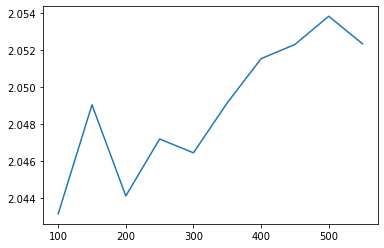

In [37]:
plt.plot(n_estimators, scores)

In [38]:
best_n_estimators = 500

In [39]:
max_depths = range(4, 15)
scores = []

for max_depth in max_depths:
    model = RandomForestRegressor(
        n_estimators=best_n_estimators, 
        max_depth=max_depth, 
        criterion='mae',  
        random_state=1)
    
    model.fit(X_train, y_train)    
    s = mean_absolute_error(model.predict(X_test), y_test)
    scores.append(s)

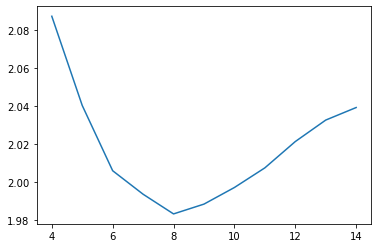

In [40]:
plt.plot(max_depths, scores)

In [41]:
best_max_depth = 9

In [42]:
rfr_model = RandomForestRegressor(n_estimators=500, max_depth=9, criterion='mae')
rfr_model.fit(X_train, y_train)
mean_absolute_error(rfr_model.predict(X_test), y_test)

1.9963762026666674

### XGBoostRegressor

In [43]:
n_estimators = range(100, 1000, 50)
scores = []

for n_estimator in n_estimators:
    model = XGBRegressor(n_estimators=n_estimator, eval_metric='mae', random_state=1)
    model.fit(X_train, y_train)    
    s = mean_absolute_error(model.predict(X_test), y_test)
    scores.append(s)

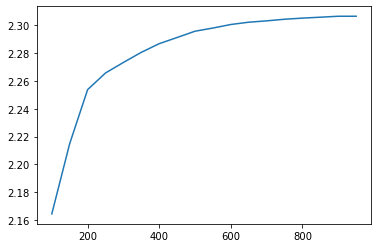

In [44]:
plt.plot(n_estimators, scores)

In [45]:
best_n_estimators = 100

In [46]:
max_depths = range(1, 50)
scores = []

for max_depth in max_depths:
    model = XGBRegressor(
        n_estimators=best_n_estimators, 
        max_depth=max_depth,
        eval_metric='mae', 
        random_state=1)
    
    model.fit(X_train, y_train)    
    s = mean_absolute_error(model.predict(X_test), y_test)
    scores.append(s)

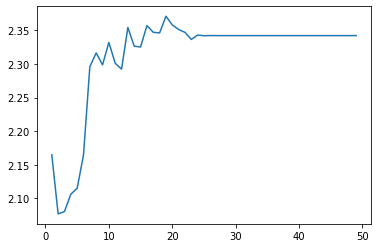

In [47]:
plt.plot(max_depths, scores)

In [48]:
best_max_depth = max_depths[scores.index(min(scores))]

In [49]:
etas = np.linspace(0.001, 1, 200)
scores = []

for eta in etas:
    model = XGBRegressor(
        n_estimators=best_n_estimators, 
        max_depth=best_max_depth,
        eta=eta,
        eval_metric='mae', 
        random_state=1)
    
    model.fit(X_train, y_train)    
    s = mean_absolute_error(model.predict(X_test), y_test)
    scores.append(s)

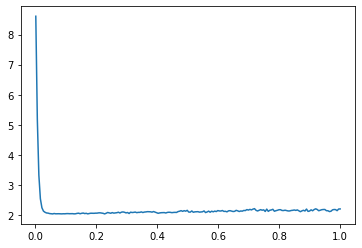

In [50]:
plt.plot(etas, scores)

In [51]:
best_eta = etas[scores.index(min(scores))]
best_eta

0.0562211055276382

In [52]:
xgb_model = XGBRegressor(
    n_estimators=best_n_estimators,
    max_depth=2,
    eta=best_eta,
    random_state=1
)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.0562211055276382,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.0562211052,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [53]:
mean_absolute_error(
    xgb_model.predict(X_test),
    y_test
)

2.0309361396706898

In [54]:
answers = rfr_model.predict(scaler.transform(df_test.drop(['DwellingId'], axis=1)))

In [55]:
ans = pd.DataFrame(columns=['DwellingId', 'Price'])
ans['DwellingId'] = df_test['DwellingId']
ans['Price'] = answers

In [56]:
ans.to_csv('answer.csv', index=False)

In [57]:
ans.head()

,DwellingId,Price
0,id2000,8.951592
1,id2001,9.212514
2,id2002,16.194506
3,id2003,6.610189
4,id2004,3.881911


In [ ]:
#Кластеризация столбцов

#Делим столбец 'Age' по возрастным группам age1=[0,4] и т. д.
df_train['AgeGroup'] = pd.cut(df_train['Age'], [0,4,18,45,75,100], right = False)
ag = pd.get_dummies(df_train['AgeGroup'])
ag.columns = ['age1','age2','age3','age4','age5']
df_train = pd.concat([df_train, ag], axis = 1)
del df_train['Age']

#Преобразуем столбец 'Name' в 'Title' по префиксам 'Mr', 'Mrs', 'Miss' и т. д.
Title = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Rare':5}
df_train['Title'] = df_train.Name.str.extract('([A-Za-z]+)\.',expand = False)
#Replace title with more common one
df_train['Title'] = df_train['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr', 
                                                'Major','Rev','Sir','Jonkheer','Dona'],'Rare')
df_train['Title'] = df_train['Title'].replace('Ms','Miss')
df_train['Title'] = df_train['Title'].replace('Mlle','Miss')
df_train['Title'] = df_train['Title'].replace('Mme','Mrs')
df_train['Title'] = df_train['Title'].map(Title)
df_train.pop('Name')